In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
churn = pd.read_csv("/Users/inesmora/Downloads/churn.csv", index_col="CustomerId")

churn = churn.drop(["RowNumber", "Surname"], axis=1) # These varaibles are not useful for our analysis

churn['Gender']=churn['Gender'].map({'Male':0, 'Female':1}) # To binary

churn = pd.get_dummies(churn, columns=['Geography'], drop_first=True, dtype=int) # One-hot encoding

churn[['HasCrCard', 'IsActiveMember', 'Exited', 'Gender']]=churn[['HasCrCard', 'IsActiveMember', 'Exited', 'Gender']].astype('category')
# To category


# Normalization
scaler = MinMaxScaler()
num_cols = churn.select_dtypes(include='number').columns
churn[num_cols] = scaler.fit_transform(churn[num_cols])

y = churn['Exited']
X = churn.drop(columns='Exited')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2025)

# Introduction

This project is a continuation of my previous work titled **“Churn Prediction with ML – Pt. 1”**, where we performed exploratory data analysis and applied several basic machine learning models such as Random Forest, SVM, and Decision Tree. In this follow-up project, we advance our approach by implementing a more powerful and sophisticated model — **XGBoost**. Our goals here are twofold: first, to train the XGBoost model and optimize its parameters for improved predictive performance, and second, to apply **SHAP** (SHapley Additive exPlanations) for model explainability. By doing so, we aim to uncover which features most significantly influence the model’s churn predictions, providing deeper insights into customer behavior.



#


=== Model 1 Parameters: {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4} ===
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87      1593
           1       0.52      0.77      0.62       407

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.81      0.82      2000

ROC-AUC Score: 0.8774498689752929


/Users/inesmora/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


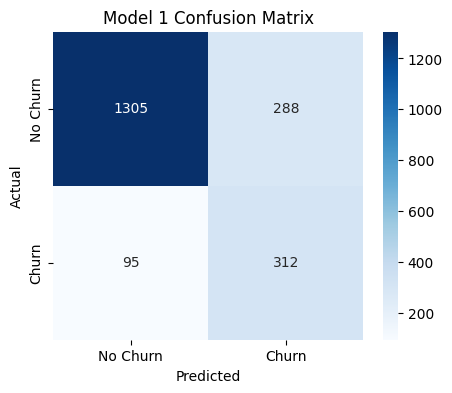

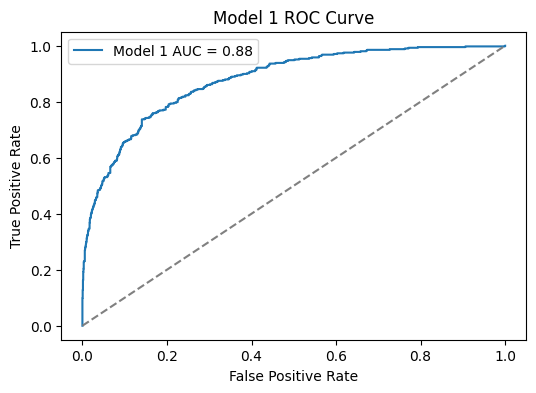

/Users/inesmora/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=== Model 2 Parameters: {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5} ===
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.83      0.87      1593
           1       0.52      0.75      0.62       407

    accuracy                           0.81      2000
   macro avg       0.73      0.79      0.75      2000
weighted avg       0.85      0.81      0.82      2000

ROC-AUC Score: 0.8763624950065628


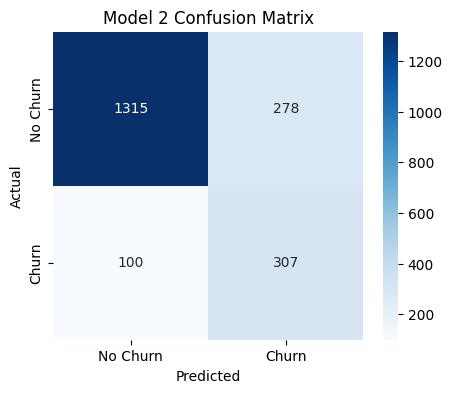

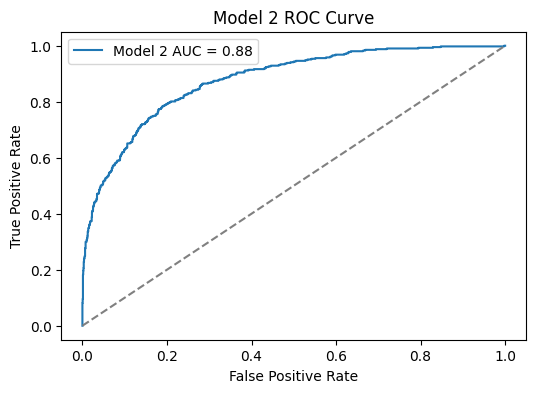


=== Model 3 Parameters: {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3} ===
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1593
           1       0.49      0.76      0.60       407

    accuracy                           0.79      2000
   macro avg       0.71      0.78      0.73      2000
weighted avg       0.84      0.79      0.81      2000

ROC-AUC Score: 0.8557478896461947


/Users/inesmora/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


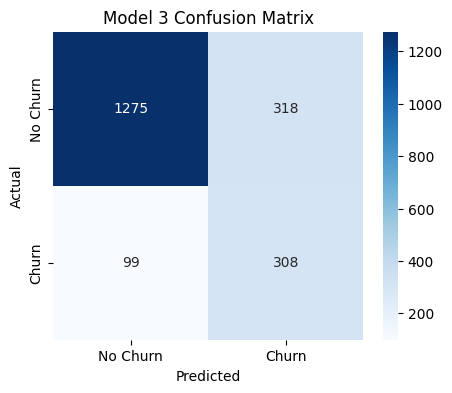

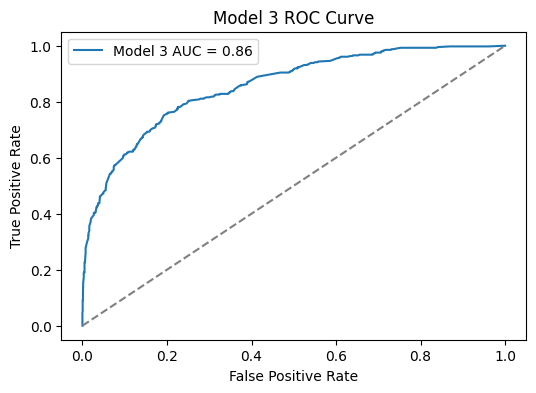

In [4]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding of categorical features
cat_cols = ['Gender', 'HasCrCard', 'IsActiveMember']
le = LabelEncoder()
for col in cat_cols:
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# List of parameter sets to compare
param_grid = [
    {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4},
    {'n_estimators': 150, 'learning_rate': 0.05, 'max_depth': 5},
    {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 3},
]

# Iteration
for i, params in enumerate(param_grid, 1):
    print(f"\n=== Model {i} Parameters: {params} ===")
    
    model = XGBClassifier(
        **params,
        scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=2025
    )
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    # metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'])
    plt.title(f'Model {i} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'Model {i} AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f'Model {i} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()


### ✅ Best Model: Model 1

* **Params:** `{'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 4}`
* **Accuracy:** 81%
* **F1-score (Churn class 1):** 0.62
* **ROC-AUC:** **0.877** ← best among the three

This model gives the best balance between **recall**, **f1-score**, and **ROC-AUC** for the positive class (churners).


In [5]:
# Final model with best parameters
best_xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=2025
)

best_xgb_model.fit(X_train, y_train)


/Users/inesmora/myenv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:58:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

# SHAP Analysis

In this section, we will leverage the `shap` (SHapley Additive exPlanations) package to interpret and explain the predictions generated by our churn prediction model. SHAP provides a unified measure of feature importance by quantifying the contribution of each variable to individual predictions. Our primary objective is to identify the key features that drive the model’s predictions, particularly focusing on those variables that significantly influence whether a customer is predicted to churn. This analysis will help us better understand the factors affecting customer churn and support more informed decision-making for retention strategies.


In [6]:
import shap

explainer = shap.Explainer(best_xgb_model, X_train)
shap_values = explainer(X_test)


/Users/inesmora/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
np.shape(shap_values.values) # (Num. of observations, Num. of shap values)

(2000, 11)

11 SHAP values for each of the observations in our dataset

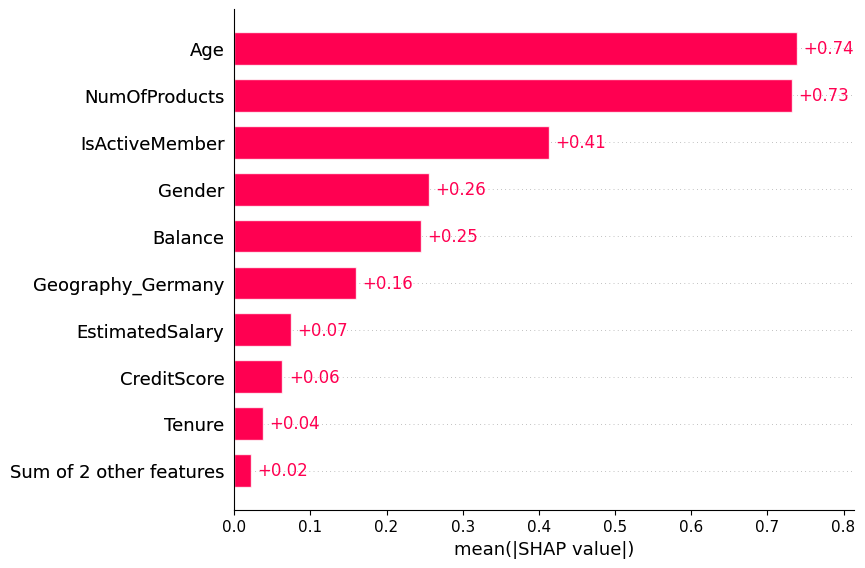

In [8]:
shap.plots.bar(shap_values)

These represent the average absolute SHAP values across all observations. Features with higher values have a greater overall influence on the model’s predictions. The most impactful features are `Age`, `NumOfProducts`, and `IsActiveMember`, in this order. However, to understand whether these variables are driving predictions toward churn or retention, we need to examine the direction of their SHAP values (positive or negative) across different data points.

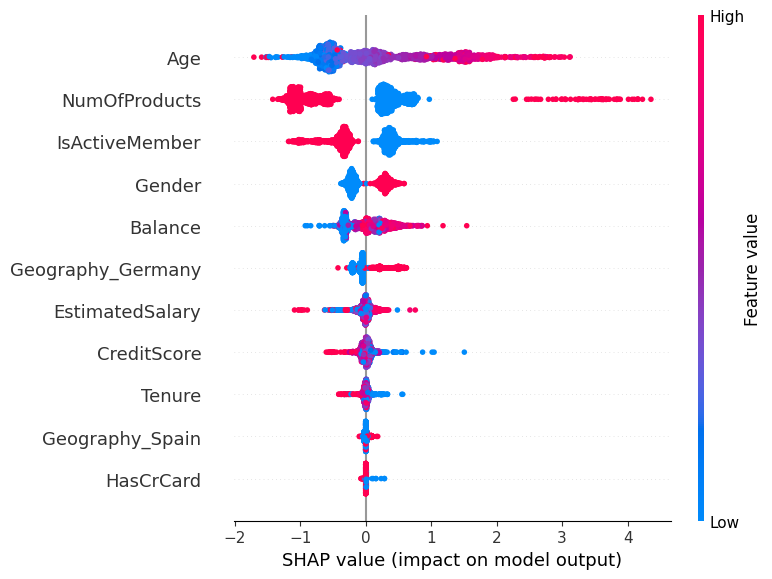

In [9]:
shap.summary_plot(shap_values, X_test)

It’s interesting to observe that older clients tend to have a higher likelihood of leaving. There’s a curious pattern regarding the number of products: generally, having more products is associated with a lower chance of churn, but we also see some cases where a high number of products corresponds to higher SHAP values for this feature, indicating increased churn risk. As expected, active members are less likely to leave. Another notable finding is that males are more prone to churn compared to females, which aligns with what we observed earlier during the Exploratory Data Analysis in part one.


The anomaly where a higher number of products mostly reduces churn risk but sometimes leads to higher SHAP values (indicating increased churn risk) could be due to interaction effects or outliers in the data. For example:

* **Interactions with other features:** In some cases, having many products might be linked to other factors that increase churn risk (e.g., product dissatisfaction, complexity of managing many products, or recent negative experiences). SHAP values capture feature contributions in the context of the whole model, so if other features signal high risk, the “number of products” feature might sometimes also show a positive contribution to churn.

* **Outliers or specific segments:** There could be a subset of clients who have many products but still churn due to specific reasons not captured by just the number of products alone, such as poor customer service or competitive offers.

* **Non-linear effects:** The relationship between number of products and churn might not be strictly linear. For example, up to a point, more products reduce churn, but beyond a threshold, the effect reverses.


In order to explore this phenomenon, we can print dependence plot with other variables to find interactions.

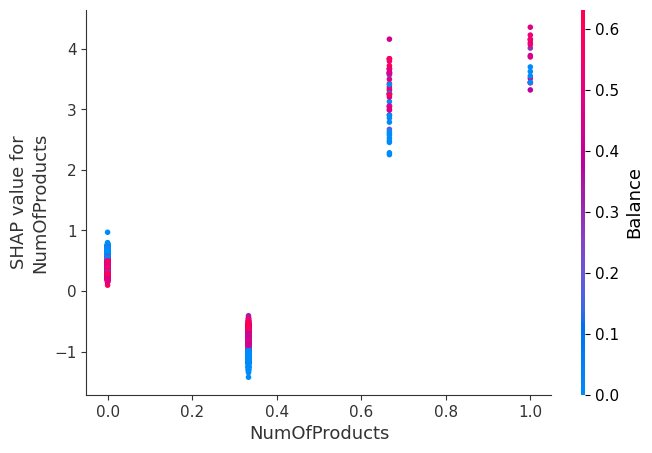

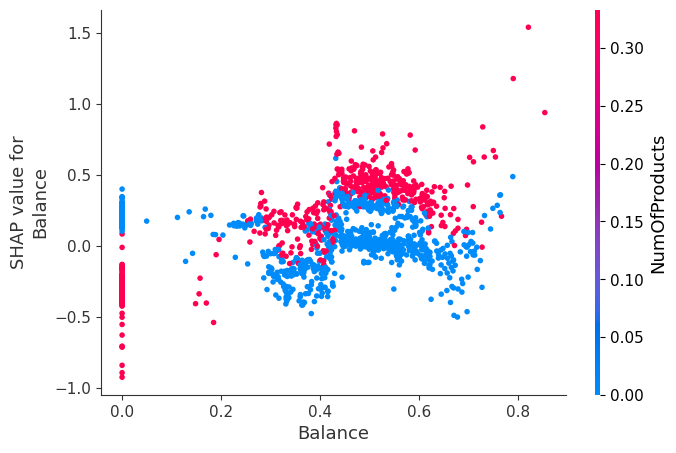

In [10]:
shap.dependence_plot('NumOfProducts', shap_values.values, X_test)


The dependence plot reveals an interaction with the variable `Balance`. It shows that customers who have both a higher number of products and a higher account balance tend to have an increased likelihood of churn according to the model’s predictions.

We can also check what other dependencies the model is detecting:


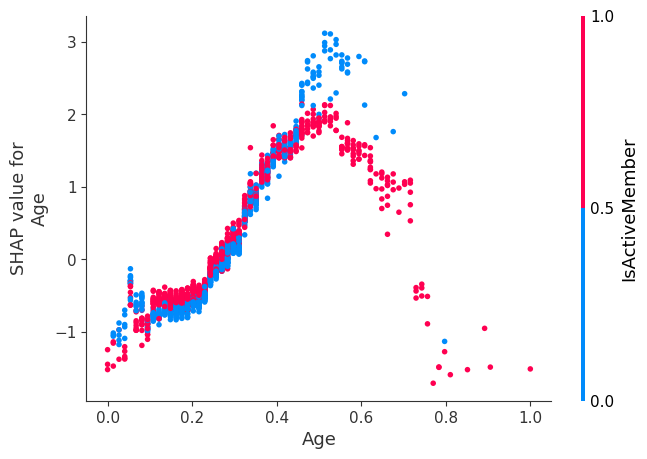

In [11]:
shap.dependence_plot('Age', shap_values.values, X_test)

This time, focusing on the most influential variable, we observe that its strongest interaction is with `IsActiveMember`, the third most important feature. The plot indicates that customers who are inactive and of average age (around 0.5 after normalization) have a higher likelihood of churn.




### Conclusions

* **Age is the dominant factor:** Older customers show higher churn risk, especially when combined with inactivity, amplifying their likelihood to leave. This highlights a vulnerable segment requiring focused attention.

* **Number of Products reveals a nuanced story:** While generally, having more products correlates with lower churn, we found an anomaly where some customers with many products still have high churn risk. The interaction between `NumOfProducts` and `Balance` indicates customers with many products and high balances are unexpectedly more likely to churn — an important anomaly that warrants qualitative follow-up (e.g., surveys or interviews) to uncover root causes.

* **Activity status (`IsActiveMember`) strongly moderates churn:** Inactive members drive much of the churn, with the highest risk among those who are both inactive and older. This interaction is a key churn driver and a prime target for re-engagement efforts.

* **Geographic differences matter:** Customers from Germany show elevated churn risk, indicating regional factors or market-specific issues affecting loyalty.

* **Other variables (Gender, CreditScore, EstimatedSalary) have lower but non-negligible influence:** These factors may still contribute marginally and could improve model refinement or segmentation strategies.

---

### Recommended Actions

1. **Segmented Retention Strategies:**

   * Prioritization of older inactive customers for personalized outreach and incentives.
   * Investigation of multi-product, high-balance customers to identify pain points— product simplification, bundling, or dedicated support could be potential mitigations.

2. **Enhanced Customer Engagement:**

   * Development of programs to reactivate inactive members, leveraging insights on age and geography.
   * Tailored communication for German customers addressing local preferences or concerns.

3. **Deep-Dive into Anomalies:**

   * Conduction of qualitative research (e.g., interviews, focus groups) targeting customers who defy general trends, such as those with many products but high churn risk, to understand dissatisfaction drivers.

4. **Regional focus on Germany**:

  * Performance of deeper analysis on customer experience and competition in Germany.
  * Introduction local promotions or improved service in this geography.

